Google colab requiere instalar estas cuatro librerías para poder ejecutar el código

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece
!pip install sentence_transformers
!pip install gradio

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:

import pandas as pd
import re
import numpy as np
import math
from bs4 import BeautifulSoup
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import socket
import pickle
from sentence_transformers import SentenceTransformer
import scipy
import os
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

En Google colab, el dataset se carga desde drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se carga el dataset. Será necesario adaptar la ruta del archivo en función de la ubicación de este. Vemos que tiene 46.844 filas y 9 columnas.

In [ ]:
data_1 = pd.read_csv(
    "/content/drive/MyDrive/workdir/data/df_colas.csv",
    sep= ";"

)
data_1

,ticket_id,ticket_type,title,customer,create_time,priority,host,solution,queue_path
0,25221.0,Incidencia Interna,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,VSTI,2020-01-01 00:00:31,3 normal,VSTIP_NEXTCLOUDDB01 - VSTIP_NEXTCLOUDDB01 - NE...,NaN,NaN
1,NaN,NaN,['OPERACION'],NaN,NaN,NaN,NaN,NaN,NaN
2,25222.0,Incidencia Interna,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,VSTI,2020-01-01 00:00:31,3 normal,VSTIP_NEXTCLOUDAPP01 - VSTIP_NEXTCLOUDAPP01 - ...,NaN,NaN
3,NaN,NaN,['OPERACION'],NaN,NaN,NaN,NaN,NaN,NaN
4,25223.0,Incidencia Interna,TICKET_AUT: ** PROBLEM Alerta de servicio: TOO...,Toolsgroup,2020-01-01 00:06:55,3 normal,TOOPWIG00004 - TOOPWIG00004,NaN,NaN
...,...,...,...,...,...,...,...,...,...
46839,53608.0,Incidencia Interna,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,BilbaoTIK,2023-02-09 11:10:27,2 low,NaN,NaN,['Negocio']
46840,53609.0,Incidencia Interna,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,BilbaoTIK,2023-02-09 11:10:27,2 low,NaN,NaN,['Negocio']
46841,53610.0,Incidencia Interna,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,BilbaoTIK,2023-02-09 11:40:06,2 low,NaN,NaN,['Negocio']
46842,53611.0,Incidencia Interna,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,BilbaoTIK,2023-02-09 11:40:07,2 low,NaN,NaN,['Negocio']


Vemos que hay muchas celdas con todo NaNs excepto la columna title, que está mal porque aparecen los queue_path. Eliminamos todas esas filas eliminando los valores nulos de la columna ticket_id.

Por otro lado, nos quedamos únicamente con las cuatro columnas que nos interesan: ticket_id, title, solution y queue_path

In [ ]:
data_1.dropna(subset='ticket_id', inplace=True)

data_1=data_1[['ticket_id', 'title', 'solution', 'queue_path']]
data_1

,ticket_id,title,solution,queue_path
0,25221.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
2,25222.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
4,25223.0,TICKET_AUT: ** PROBLEM Alerta de servicio: TOO...,NaN,NaN
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
7,25225.0,Tareas de mantenimiento Sidenor,NaN,['Soporte Windows']
...,...,...,...,...
46839,53608.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46840,53609.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46841,53610.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']
46842,53611.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']


El dataset se reduce a 28.294 filas.

In [ ]:
data_1.isna().sum()

ticket_id         0
title             3
solution      26186
queue_path    18550
dtype: int64

De 28294 incidencias, 18550 no tienen grupo asignado y 26186 no tienen solución. Se calcula el total de tickets con grupo asignado y el total de grupos con solución

In [ ]:
grupos_no_nulos = data_1.dropna(subset="queue_path")
con_solucion = data_1.dropna(subset="solution")
print("tickets con grupo :", len(grupos_no_nulos))
print("tickets con solucion :", len(con_solucion))

tickets con grupo : 9744
tickets con solucion : 2108


Se eliminan las incidencias con solución o queue_path nulos

In [ ]:
data_1.dropna(subset=["solution", "queue_path"])

,ticket_id,title,solution,queue_path
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
94,25284.0,SoftTSU,Cerramos incidencia en el sistema de gestión d...,['ADM SISTEMAS']
154,25321.0,Dar permisos a Eduardo Moraleja al vcenter VERSIA,Se realiza el cambio junto con Soporte Usuarios.,['ADM SISTEMAS']
174,25336.0,TICKET_AUT: ** PROBLEM Alerta de servicio: SYC...,Se comprueba que la alerta por bloqueos ya no ...,['ADM SISTEMAS']
181,25342.0,Recuperación IMQ,Se procede a la recuperación del perfil en la ...,['OPERACION']
...,...,...,...,...
46788,53565.0,Re: Errores de inicio de sesión,Se esta revisando desde CAU BAM,['ADM SISTEMAS']
46797,53574.0,Baja monitorizacion,Ya se pidio la baja del servidor en el siguien...,['ADM SISTEMAS']
46801,53578.0,RV: Informe incidencias Enero 2023,Se cambia en la notificaciones de los tickets ...,['ADM SISTEMAS']
46803,53580.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,La version de Horizon actual es 7.12. \r\n\r\n...,"['Negocio', 'Soporte Windows', 'Soporte Vmware']"


Hay un total de 477 secuencias de grupos. Es decir, hay un total de 477 categorías

In [ ]:
grupos_no_nulos["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                                                                                                                              3342
['Soporte Gestion Usuarios']                                                                                                                  1174
['Soporte Utilities PyC']                                                                                                                     1035
['ADM SISTEMAS', 'Soporte BackUp']                                                                                                             445
['SoporteFunc BiscayTIk']                                                                                                                      371
                                                                                                                                              ... 
['SoporteFunc BiscayTIk', 'Soporte Comunicaciones', 'ADM SISTEMAS', 'SoporteFunc BiscayTIk']               

Vemos ahora cuántas categorías hay con más de 15 registros. Un total de 34

In [ ]:
conteo= grupos_no_nulos["queue_path"].value_counts()
cat34= conteo[conteo> 15]

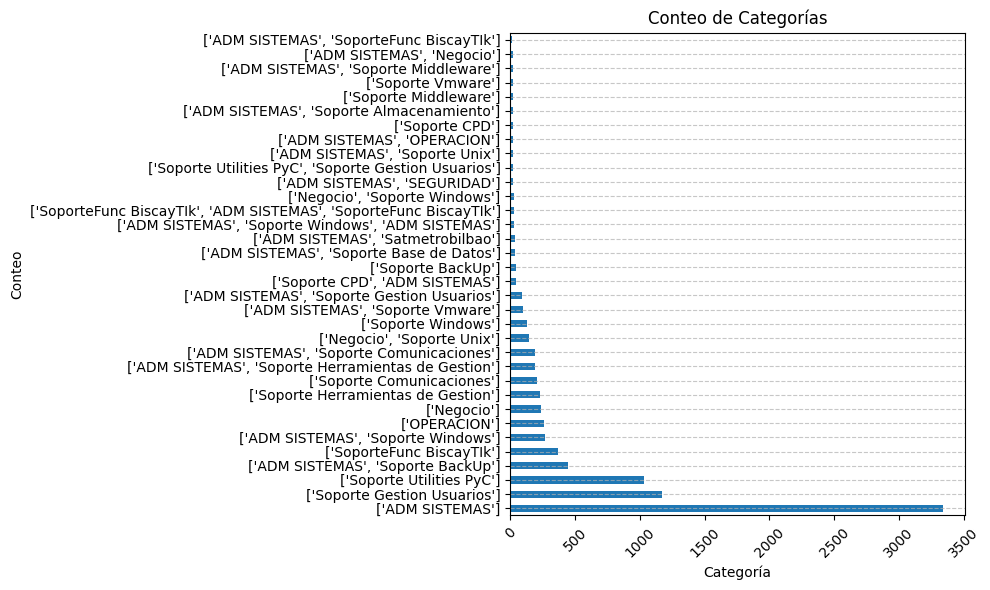

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
cat34.plot(kind='barh')
plt.title('Conteo de Categorías')
plt.xlabel('Categoría')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Esta es la distribución de las 34 categorías más frecuentes. 17 de ellas cuentan aún con muy pocos registros.Se muestran ahora los 15 grupos más frecuentes y la distribución de los grupos

In [ ]:
a = grupos_no_nulos.groupby("queue_path")['ticket_id'].count().reset_index().sort_values('ticket_id', ascending=False)
a[:15]  # 15 grupos para categorizar

,queue_path,ticket_id
182,['ADM SISTEMAS'],3342
397,['Soporte Gestion Usuarios'],1174
429,['Soporte Utilities PyC'],1035
51,"['ADM SISTEMAS', 'Soporte BackUp']",445
476,['SoporteFunc BiscayTIk'],371
176,"['ADM SISTEMAS', 'Soporte Windows']",267
264,['OPERACION'],258
254,['Negocio'],235
412,['Soporte Herramientas de Gestion'],229
389,['Soporte Comunicaciones'],205


In [ ]:
a = data_1.groupby("queue_path")['ticket_id'].count().reset_index().sort_values('ticket_id', ascending=False)
sum(a['ticket_id'][:15])



8306

<Axes: >

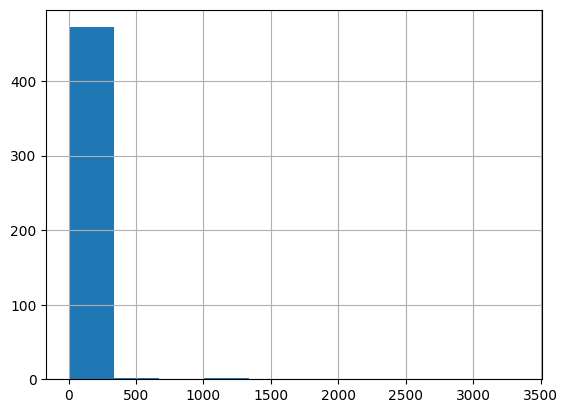

In [ ]:
data_1["queue_path"].value_counts().hist()

La mayoría de los grupos tienen una frecuencia de entre 0 y 400 incidencias aproximadamente. Únicamente hay 4 grupos por encima de ese rango

In [ ]:
data_1.dropna(subset= "ticket_id")

,ticket_id,title,solution,queue_path
0,25221.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
2,25222.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
4,25223.0,TICKET_AUT: ** PROBLEM Alerta de servicio: TOO...,NaN,NaN
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
7,25225.0,Tareas de mantenimiento Sidenor,NaN,['Soporte Windows']
...,...,...,...,...
46839,53608.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46840,53609.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46841,53610.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']
46842,53611.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']


In [ ]:
data= grupos_no_nulos
data

,ticket_id,title,solution,queue_path
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
7,25225.0,Tareas de mantenimiento Sidenor,NaN,['Soporte Windows']
10,25227.0,Ifaces y vlanes 02/01/2020,NaN,['Soporte Herramientas de Gestion']
11,25228.0,Alta / Modificación Usuario - Resetear contras...,NaN,['Soporte Gestion Usuarios']
12,25229.0,Alta / Modificación Usuario - Resetear contras...,NaN,['Soporte Gestion Usuarios']
...,...,...,...,...
46839,53608.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46840,53609.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46841,53610.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']
46842,53611.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']


Ahora guardo dos variables, una para el clasificador y otra con soluciones para la interfaz posterior

In [ ]:
data_1= data.drop(["solution", "ticket_id"], axis=1)
data_2= data.drop(["ticket_id", "queue_path"], axis= 1)

In [ ]:
data_1

,title,queue_path
6,TICKET_AUT: licencia servidor backup cires,['Soporte BackUp']
7,Tareas de mantenimiento Sidenor,['Soporte Windows']
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion']
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']


In [ ]:
data_1["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                                                                                                                              3342
['Soporte Gestion Usuarios']                                                                                                                  1174
['Soporte Utilities PyC']                                                                                                                     1035
['ADM SISTEMAS', 'Soporte BackUp']                                                                                                             445
['SoporteFunc BiscayTIk']                                                                                                                      371
                                                                                                                                              ... 
['SoporteFunc BiscayTIk', 'Soporte Comunicaciones', 'ADM SISTEMAS', 'SoporteFunc BiscayTIk']               

Se visualizan las 10 categorías más frecuentes y se decide trabajar únicamente con ellas para disponer de un número razonable de muestras en cada categoría a clasificar.

In [ ]:
conteo= data_1["queue_path"].value_counts()
cat10= conteo[conteo>=200]
cat10


queue_path
['ADM SISTEMAS']                       3342
['Soporte Gestion Usuarios']           1174
['Soporte Utilities PyC']              1035
['ADM SISTEMAS', 'Soporte BackUp']      445
['SoporteFunc BiscayTIk']               371
['ADM SISTEMAS', 'Soporte Windows']     267
['OPERACION']                           258
['Negocio']                             235
['Soporte Herramientas de Gestion']     229
['Soporte Comunicaciones']              205
Name: count, dtype: int64

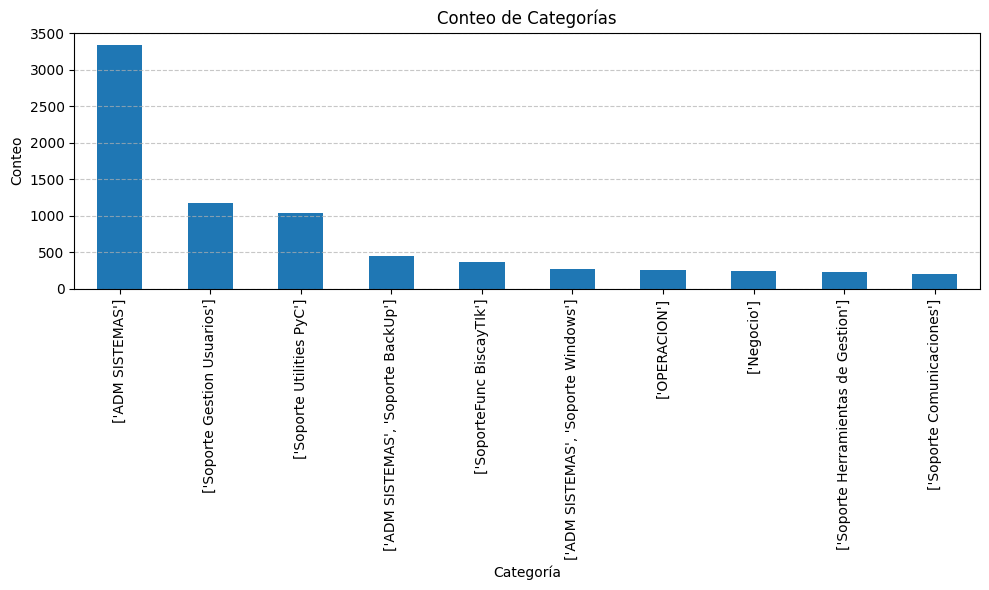

In [ ]:
plt.figure(figsize=(10, 6))
cat10.plot(kind='bar')
plt.title('Conteo de Categorías')
plt.xlabel('Categoría')
plt.ylabel('Conteo')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Se aprecia un desbalanceo obvio. No obstante, se han realizado pruebas con técnicas como SMOTE o RandomOverSampling y no se obtienen buenos resultados. Se decide trabajar con el conjunto tal cual está.

In [ ]:
cat10= cat10.index.tolist()



In [ ]:
cat10

["['ADM SISTEMAS']",
 "['Soporte Gestion Usuarios']",
 "['Soporte Utilities PyC']",
 "['ADM SISTEMAS', 'Soporte BackUp']",
 "['SoporteFunc BiscayTIk']",
 "['ADM SISTEMAS', 'Soporte Windows']",
 "['OPERACION']",
 "['Negocio']",
 "['Soporte Herramientas de Gestion']",
 "['Soporte Comunicaciones']"]

Ahora se crea el dataset con el que se va a trabajar añadiendo únicamente las 10 categorías más frecuentes, almacenadas en la variable cat10

In [ ]:
data_final= data_1[data_1["queue_path"].isin(cat10)]
data_final

,title,queue_path
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion']
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
30,Errores con el correo de producción de IPTN,['ADM SISTEMAS']
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS']
...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']


In [ ]:
data_final= data_final.dropna()

Y esta es la distribución de las categorías que habrá que clasificar.

In [ ]:
data_final["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       3342
['Soporte Gestion Usuarios']           1174
['Soporte Utilities PyC']              1034
['ADM SISTEMAS', 'Soporte BackUp']      445
['SoporteFunc BiscayTIk']               371
['ADM SISTEMAS', 'Soporte Windows']     267
['OPERACION']                           258
['Negocio']                             235
['Soporte Herramientas de Gestion']     229
['Soporte Comunicaciones']              205
Name: count, dtype: int64

## Limpieza

Se definen estas funciones para limpiar el texto. Se eliminan tags HTML, URLs, signos de puntuación, caracteres especiales, números y expacios en blanco extra

In [ ]:
def remove_html_tags_func(text): # Esta función elimina cualquier tag HTML que pueda haber en alguna incidencia.

    return BeautifulSoup(text, 'html.parser').get_text()


def remove_url_func(text): # Esta se encarga de eliminar posibles URLs que no hacen más que aumentar el ruido de los datos.

    return re.sub(r'https?://\S+|www\.\S+', '', text)


def remove_punctuation_func(text): # Se eliminan signos de puntuación como comas, puntos etc para facilitar la tokenización

    return re.sub(r'[^a-zA-Z0-9]', ' ', text)


def remove_irr_char_func(text): # Se eliminan números

    return re.sub(r'[^a-zA-Z]', ' ', text)


def remove_extra_whitespaces_func(text): # Al aplicar las funciones anteriores, muchos de los elementos eliminados se sustituyen por espacios en blanco. Esto puede dificultar la tokenización --> Se eliminan.

    return re.sub(r'^\s*|\s\s*', ' ', text).strip()






Ya con las funciones definidas se aplican a la columna title que contiene los textos y se crea la columna clean_title

In [ ]:
#data_final['clean_title'] = data_final['title'].str.lower()
data_final['clean_title'] = data_final['title'].apply(remove_html_tags_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_url_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_punctuation_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_irr_char_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_extra_whitespaces_func)



<ipython-input-116-01e79961b35a>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()
<ipython-input-117-40ad2c4ddaf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['clean_title'] = data_final['title'].apply(remove_html_tags_func)
<ipython-input-117-40ad2c4ddaf0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['clean_titl

Se dispone de 7560 incidencias

In [ ]:
data_final

,title,queue_path,clean_title
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion'],Ifaces y vlanes
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...
30,Errores con el correo de producción de IPTN,['ADM SISTEMAS'],Errores con el correo de producci n de IPTN
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS'],Solicitud de cambio de cintas justicia
...,...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...


In [ ]:
data_final["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       3342
['Soporte Gestion Usuarios']           1174
['Soporte Utilities PyC']              1034
['ADM SISTEMAS', 'Soporte BackUp']      445
['SoporteFunc BiscayTIk']               371
['ADM SISTEMAS', 'Soporte Windows']     267
['OPERACION']                           258
['Negocio']                             235
['Soporte Herramientas de Gestion']     229
['Soporte Comunicaciones']              205
Name: count, dtype: int64

In [ ]:
data_final["queue_path"].unique()

array(["['Soporte Herramientas de Gestion']",
       "['Soporte Gestion Usuarios']", "['ADM SISTEMAS']",
       "['Soporte Comunicaciones']", "['Soporte Utilities PyC']",
       "['OPERACION']", "['ADM SISTEMAS', 'Soporte BackUp']",
       "['ADM SISTEMAS', 'Soporte Windows']", "['SoporteFunc BiscayTIk']",
       "['Negocio']"], dtype=object)

Como el modelo necesita categorías numéricas y los grupos están en cadenas de texto, se crea un diccionario asignando un número a cada grupo para hacer después un mapeo

In [ ]:
categorias_dict = {
    "['ADM SISTEMAS']": 0,
    "['Soporte Gestion Usuarios']": 1,
    "['Soporte Utilities PyC']": 2,
    "['ADM SISTEMAS', 'Soporte BackUp']": 3,
    "['SoporteFunc BiscayTIk']": 4,
    "['ADM SISTEMAS', 'Soporte Windows']": 5,
    "['OPERACION']": 6,
    "['Negocio']": 7,
    "['Soporte Herramientas de Gestion']": 8,
    "['Soporte Comunicaciones']": 9
}

In [ ]:
data_final["categoria"]= data_final["queue_path"].map(categorias_dict)

<ipython-input-122-1617d5e0342c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final["categoria"]= data_final["queue_path"].map(categorias_dict)


In [ ]:
data_final

,title,queue_path,clean_title,categoria
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion'],Ifaces y vlanes,8
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...,1
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...,1
30,Errores con el correo de producción de IPTN,['ADM SISTEMAS'],Errores con el correo de producci n de IPTN,0
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS'],Solicitud de cambio de cintas justicia,0
...,...,...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...,7
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...,7
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...,7
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...,7


Se define la función para pasar los tokens a ids numéricos. Esta se usará después de crear el tokenizador.


In [ ]:
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [ ]:
data_final.dtypes

title          object
queue_path     object
clean_title    object
categoria       int64
dtype: object

Se divide el dataset en train, test y validation manteniendo las proporciones de los grupos con el stratify. Como hay pocos datos se hace la división 60-20-20 para que haya suficientes datos en test y validation. No obstante, se han probado diferentes particiones, y esta es la que mejores resultados ofrece porque se mantienen suficientes datos en el conjunto de entrenamiento para que el modelo identifique patrones y al mismo tiempo los conjuntos de test y validación cuentan con suficientes muestras de cada clase.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_final, test_size=0.2, stratify=data_final['queue_path'], random_state= 43)


In [ ]:
train_df, val_df= train_test_split(train_df, test_size= 0.2, stratify= train_df["queue_path"], random_state= 43)

Estas son las distribuciones en cada conjunto de datos.

In [ ]:
train_df["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       2139
['Soporte Gestion Usuarios']            751
['Soporte Utilities PyC']               662
['ADM SISTEMAS', 'Soporte BackUp']      285
['SoporteFunc BiscayTIk']               238
['ADM SISTEMAS', 'Soporte Windows']     171
['OPERACION']                           165
['Negocio']                             150
['Soporte Herramientas de Gestion']     146
['Soporte Comunicaciones']              131
Name: count, dtype: int64

In [ ]:
test_df["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       668
['Soporte Gestion Usuarios']           235
['Soporte Utilities PyC']              207
['ADM SISTEMAS', 'Soporte BackUp']      89
['SoporteFunc BiscayTIk']               74
['ADM SISTEMAS', 'Soporte Windows']     53
['OPERACION']                           52
['Negocio']                             47
['Soporte Herramientas de Gestion']     46
['Soporte Comunicaciones']              41
Name: count, dtype: int64

In [ ]:
val_df["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       535
['Soporte Gestion Usuarios']           188
['Soporte Utilities PyC']              165
['ADM SISTEMAS', 'Soporte BackUp']      71
['SoporteFunc BiscayTIk']               59
['ADM SISTEMAS', 'Soporte Windows']     43
['OPERACION']                           41
['Negocio']                             38
['Soporte Herramientas de Gestion']     37
['Soporte Comunicaciones']              33
Name: count, dtype: int64

## Tokenizador

Se crea el tokenizador de bert que se va a utilizar. Para ello se carga el modelo preentrenado. En este caso se utiliza un modelo multilingüe capaz de distinguir entre mayúsculas y minúsculas. Sus especificaciones están detalladas en la memoria del proyecto.

In [ ]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",
                                # solo ingles: tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                                trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

Vemos el tamaño del vocabulario del tokenizador, que es un hiperparámetro que después habrá que utilizar.

In [ ]:
vocab= tokenizer.vocab()
vocab_size= len(vocab)
vocab_size

Creo los inputs del modelo con la función previamente definida. Me tokeniza las frases y me cambia los tokens por ids numéricos únicos

In [ ]:
data_inputs = [encode_sentence(sentence) for sentence in data_final["clean_title"]]
data_inputs

[[14535, 19929, 10107, 193, 190, 25920, 10107],
 [22798,
  78616,
  44480,
  10598,
  182,
  27582,
  62944,
  32070,
  14766,
  10354,
  11473,
  10341,
  169,
  15631,
  65689,
  25819],
 [22798,
  78616,
  44480,
  10598,
  182,
  27582,
  62944,
  32070,
  14766,
  10354,
  11473,
  10341,
  169,
  17749,
  14178,
  12061,
  10305],
 [10915,
  70768,
  10107,
  10173,
  10125,
  64741,
  10133,
  10104,
  11284,
  87150,
  10598,
  182,
  10104,
  24124,
  11090,
  11537],
 [19655, 13439, 16107, 10104, 19272, 10104, 36479, 10107, 86847],
 [13968, 47543, 104679, 182, 10104, 10182, 30909, 10107, 18484, 39393],
 [13968,
  47543,
  104679,
  182,
  10104,
  10182,
  16011,
  33743,
  10107,
  10104,
  39999,
  11517],
 [34222, 10110, 20010, 10113, 24757, 10104, 17524, 14888],
 [96672, 10133, 20886],
 [152, 104847, 11403, 44271, 15468, 33453, 10321, 70917],
 [22798,
  78616,
  44480,
  10598,
  182,
  27582,
  62944,
  32070,
  14766,
  10354,
  11473,
  10341,
  169,
  24354,
  34987,


Al tener conjuntos de train, test y val lo hago para todos los conjuntos. A partir de aquí, todos los pasos se repiten 3 veces, una para cada conjunto.

In [ ]:
train_inputs= [encode_sentence(sentence) for sentence in train_df["clean_title"]]
test_inputs= [encode_sentence(sentence) for sentence in test_df["clean_title"]]
val_inputs= [encode_sentence(sentence) for sentence in val_df["clean_title"]]

Aquí creo el dataset en formato tensorFlow que Bert es capaz de procesar. El proceso está explicado en la memoria. En este paso se establece también el tamaño de cada lote en 32.
 La parte del código entre almohadillas es una prueba que se realizó al principio sin conjunto de validación.

In [ ]:
data_labels = data_final.categoria.values
data_with_len = [[sent, data_labels[i], len(sent)]
                     for i, sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [(sent_lab[0], sent_lab[1])
                  for sent_lab in data_with_len if sent_lab[2] > 5]
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                                 output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None,), ()))

#NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
#NB_BATCHES_TEST = NB_BATCHES // 10
#all_batched.shuffle(NB_BATCHES)
#test_dataset = all_batched.take(NB_BATCHES_TEST)
#train_dataset = all_batched.skip(NB_BATCHES_TEST)

Ese era el dataset completo. Ahora se crea para cada uno de los conjuntos de datos. Estos son los que se le pasarán al modelo

In [ ]:
# Train
data_labels_train = train_df.categoria.values
data_with_len_train = [[sent, data_labels_train[i], len(sent)]
                     for i, sent in enumerate(train_inputs)]
random.shuffle(data_with_len_train)
data_with_len_train.sort(key=lambda x: x[2])
sorted_all_train = [(sent_lab[0], sent_lab[1])
                  for sent_lab in data_with_len_train if sent_lab[2] > 5]
all_dataset_train = tf.data.Dataset.from_generator(lambda: sorted_all_train,
                                                 output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched_train = all_dataset_train.padded_batch(BATCH_SIZE, padded_shapes=((None,), ()))

# Test
data_labels_test = test_df.categoria.values
data_with_len_test = [[sent, data_labels_test[i], len(sent)]
                     for i, sent in enumerate(test_inputs)]
random.shuffle(data_with_len_test)
data_with_len_test.sort(key=lambda x: x[2])
sorted_all_test = [(sent_lab[0], sent_lab[1])
                  for sent_lab in data_with_len_test if sent_lab[2] > 5]
all_dataset_test = tf.data.Dataset.from_generator(lambda: sorted_all_test,
                                                 output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched_test = all_dataset_test.padded_batch(BATCH_SIZE, padded_shapes=((None,), ()))

# Validation
data_labels_val = val_df.categoria.values
data_with_len_val = [[sent, data_labels_val[i], len(sent)]
                     for i, sent in enumerate(val_inputs)]
random.shuffle(data_with_len_val)
data_with_len_val.sort(key=lambda x: x[2])
sorted_all_val = [(sent_lab[0], sent_lab[1])
                  for sent_lab in data_with_len_val if sent_lab[2] > 5]
all_dataset_val = tf.data.Dataset.from_generator(lambda: sorted_all_val,
                                                 output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched_val = all_dataset_val.padded_batch(BATCH_SIZE, padded_shapes=((None,), ()))

In [ ]:
train_dataset= all_batched_train
test_dataset= all_batched_test
val_dataset= all_batched_val

Esta es la arquitectura de la red neuronal, ya explicada en la memoria

In [ ]:

class DCNN(tf.keras.Model):
    def __init__(self,
                vocab_size,
                emb_dim=128,
                nb_filters=50,
                FFN_units=512,
                nb_classes=2,
                dropout_rate=0.1,
                name="dcnn"):
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",
                                    activation="relu")
        self.pool = layers.GlobalMaxPool1D()

        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)  # (batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1)  # (batch_size, nb_filters)
        x_2 = self.trigram(x)  # (batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2)  # (batch_size, nb_filters)
        x_3 = self.fourgram(x)  # (batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3)  # (batch_size, nb_filters)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training=training)
        output = self.last_dense(merged)

        return output

Se especifican los hiperparámetros y los criterios para hacer el compile

In [ ]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 64
FFN_UNITS = 128
NB_CLASSES = data_final.categoria.nunique()

DROPOUT_RATE = 0.2

NB_EPOCHS = 30

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

Las almohadillas de los siguientes pasos corresponden con un checkpoint creado para guardar los resultados del modelo y no tener que estar constantemente entrenándolo. Se dejan simplemente para mostrar cómo se hicieron.

In [ ]:

#checkpoint_path = ruta donde se guarda el checkpoint

#ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

#ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

    #if ckpt_manager.latest_checkpoint:
     #   ckpt.restore(ckpt_manager.latest_checkpoint)
      #  print("Último checkpoint restaurado!!")

Se define el early_stopping y su criterio de parada. Monitoria la función de pérdida en el conjunto de validación con una paciencia de tres épocas, por lo que si pasan tres épocas seguidas sin disminuir la pérdida en el conjunto de validación el entrenamiento parará quedándose con las métricas de la época con la pérdida mínima.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=3,
                                                      restore_best_weights=True)

#class MyCustomCallback(tf.keras.callbacks.Callback):

 #   def on_epoch_end(self, epoch, logs=None):
  #      ckpt_manager.save()
   #     print("Checkpoint guardado en {}.".format(checkpoint_path))




Se entrena el modelo especificándole que entrene con el conjunto de entrenamiento y que realice la validación con el conjunto de validación. Con el early_stopping para en la época 7, quedándose con las métricas de la época 4 antes de empezar a sobreajustarse. En esa época la accuracy del entrenamiento es del 95,81% y la del conjunto de validación del 87,52% con una pérdida de 0,4301.

In [ ]:
history= Dcnn.fit(train_dataset,
        epochs=NB_EPOCHS,
        validation_data= val_dataset,
        #callbacks=[[MyCustomCallback(),  early_stopping]])
        callbacks= [early_stopping])

Epoch 1/30
142/142 [==============================] - 23s 144ms/step - loss: 1.1305 - sparse_categorical_accuracy: 0.6588 - val_loss: 0.6759 - val_sparse_categorical_accuracy: 0.7965
Epoch 2/30
142/142 [==============================] - 3s 20ms/step - loss: 0.5220 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.4796 - val_sparse_categorical_accuracy: 0.8372
Epoch 3/30
142/142 [==============================] - 3s 19ms/step - loss: 0.2804 - sparse_categorical_accuracy: 0.9163 - val_loss: 0.4329 - val_sparse_categorical_accuracy: 0.8655
Epoch 4/30
142/142 [==============================] - 2s 15ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.4301 - val_sparse_categorical_accuracy: 0.8752
Epoch 5/30
142/142 [==============================] - 2s 14ms/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.4938 - val_sparse_categorical_accuracy: 0.8779
Epoch 6/30
142/142 [==============================] - 3s 20ms/step - loss: 0.0973 - sparse_ca

Se plotean la accuracy y la pérdida en train y en validation y se aprecia cómo a partir de la época 4 tanto la accuracy como la pérdida del conjunto de validación empiezan a empeorar a cambio de una mejoría mínima en el conjunto de entrenamiento, indicando el sobreajuste.

<ipython-input-142-6c5110a4f60c>:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo-', label='Training Loss', marker= "o")


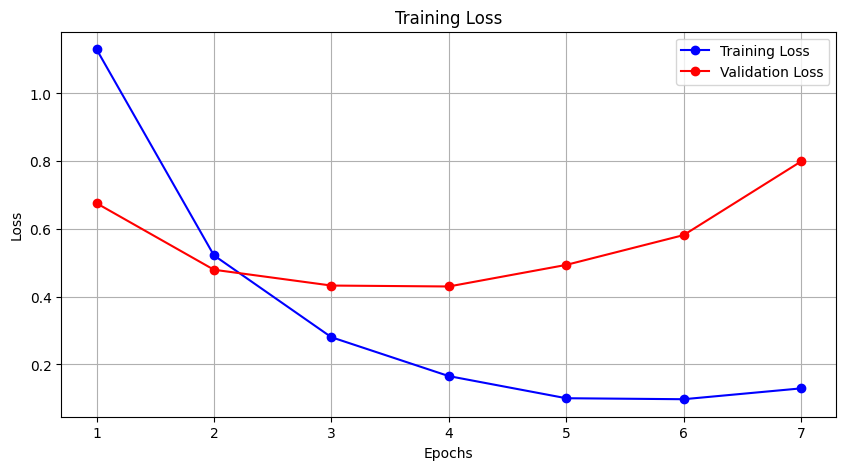

<ipython-input-142-6c5110a4f60c>:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy', marker= "o")


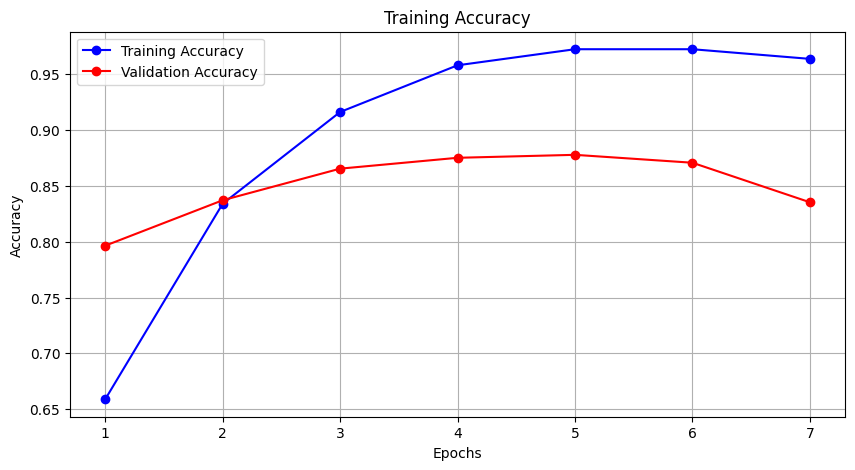

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss= history.history["val_loss"]
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy= history.history["val_sparse_categorical_accuracy"]
epochs = range(1, len(loss) + 1)

# Plot de loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss', marker= "o")
plt.plot(epochs, val_loss, 'r-', label='Validation Loss', marker= "o")
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot de accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy', marker= "o")
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy', marker= "o")

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Se evalúa en el conjunto de test obteniendo una accuracy del 90% y una pérdida en el conjunto de entrenamiento de 0,3267. Teniendo en cuenta que se dispone de 10 categorías bastante desequilibradas entre sí, es un rendimiento bastante aceptable. Un clasificador aleatorio tendría una precisión del 10%.

In [ ]:
results = Dcnn.evaluate(test_dataset)
print(results)


45/45 [==============================] - 1s 23ms/step - loss: 0.3267 - sparse_categorical_accuracy: 0.9000
[0.32672154903411865, 0.8999999761581421]


Se calculan las métricas manualmente también, por si acaso

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

losses = []
accuracies = []

for x_batch, y_batch in all_batched_test:
    logits = Dcnn(x_batch, training=False)

    # La pérdida
    loss_value = loss_fn(y_batch, logits).numpy()
    losses.append(loss_value)

    # La accuracy
    preds = tf.argmax(logits, axis=-1, output_type=tf.int64)
    y_batch = tf.cast(y_batch, tf.int64)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, y_batch), tf.float32)).numpy()
    accuracies.append(accuracy)

# Sacamos la media
average_loss = np.mean(losses)
average_accuracy = np.mean(accuracies)

print(f"Manual Evaluation - Loss: {average_loss}, Accuracy: {average_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Manual Evaluation - Loss: 0.32250741124153137, Accuracy: 0.9013888835906982


In [ ]:
data_final

,title,queue_path,clean_title,categoria
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion'],Ifaces y vlanes,8
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...,1
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...,1
30,Errores con el correo de producción de IPTN,['ADM SISTEMAS'],Errores con el correo de producci n de IPTN,0
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS'],Solicitud de cambio de cintas justicia,0
...,...,...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...,7
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...,7
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...,7
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...,7


Se crea un df con las categorías y los grupos únicamente para hacer predicciones

In [ ]:
df_maestro= data_final[["queue_path", "categoria"]].drop_duplicates().reset_index()
df_maestro= df_maestro.drop("index", axis= 1)
df_maestro

,queue_path,categoria
0,['Soporte Herramientas de Gestion'],8
1,['Soporte Gestion Usuarios'],1
2,['ADM SISTEMAS'],0
3,['Soporte Comunicaciones'],9
4,['Soporte Utilities PyC'],2
5,['OPERACION'],6
6,"['ADM SISTEMAS', 'Soporte BackUp']",3
7,"['ADM SISTEMAS', 'Soporte Windows']",5
8,['SoporteFunc BiscayTIk'],4
9,['Negocio'],7


In [ ]:
df_maestro.dtypes

queue_path    object
categoria      int64
dtype: object

Se define la función para obtener las predicciones en base a una frase. Para ello, se definen los tokens, las entradas al modelo (inputs) y las salidas (outputs).

In [ ]:
def get_prediction(sentence):
        tokens = encode_sentence(sentence)
        inputs = tf.expand_dims(tokens, 0)

        output = Dcnn(inputs, training=False)

        return df_maestro[df_maestro.categoria == np.argmax(output.numpy())]

get_prediction("Problemas con hacienda")


,queue_path,categoria
7,"['ADM SISTEMAS', 'Soporte Windows']",5


Creo esta función para crear luego dos columnas, una con el grupo predicho y otro con la categoría predicha. Así al añadirlas al df se puede hacer la comparativa entre la clase real y la clase predicha.

In [ ]:
def get_prediction(row):
    try:
        tokens = encode_sentence(row['clean_title'])
        inputs = tf.expand_dims(tokens, 0)

        output = Dcnn(inputs, training=False)
        df_result = df_maestro[df_maestro.categoria == np.argmax(output.numpy())]
        result1 = df_result.values[0][0]
        result2 = df_result.values[0][1]
    except:
        result1 = None
        result2 = None

    return (result1, result2)

In [ ]:
df= data_final[["clean_title", "queue_path","categoria"]]

Aquí se aplica a todo el dataset

In [ ]:
new_rows = data_final.apply(get_prediction, axis=1, result_type='expand')
df['bert_predict_cola'] = new_rows.iloc[:, 0]
df['bert_predict_clase'] = new_rows.iloc[:, 1]

In [ ]:
df

,clean_title,queue_path,categoria,bert_predict_cola,bert_predict_clase
10,Ifaces y vlanes,['Soporte Herramientas de Gestion'],8,['Soporte Herramientas de Gestion'],8.0
11,Alta Modificaci n Usuario Resetear contrase a ...,['Soporte Gestion Usuarios'],1,['Soporte Gestion Usuarios'],1.0
12,Alta Modificaci n Usuario Resetear contrase a ...,['Soporte Gestion Usuarios'],1,['Soporte Gestion Usuarios'],1.0
30,Errores con el correo de producci n de IPTN,['ADM SISTEMAS'],0,['ADM SISTEMAS'],0.0
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS'],0,['OPERACION'],6.0
...,...,...,...,...,...
46839,JIRA SISTEMAS Instalaci n de aplicaci n docker...,['Negocio'],7,['Negocio'],7.0
46840,JIRA SISTEMAS Instalaci n de aplicaci n docker...,['Negocio'],7,['Negocio'],7.0
46841,JIRA SISTEMAS Validar la compatibilidad de Hor...,['Negocio'],7,['Negocio'],7.0
46842,JIRA SISTEMAS Validar la compatibilidad de Hor...,['Negocio'],7,['Negocio'],7.0


In [ ]:
df.isna().sum()

clean_title            0
queue_path             0
categoria              0
bert_predict_cola     54
bert_predict_clase    54
dtype: int64

In [ ]:
df.dtypes

clean_title            object
queue_path             object
categoria               int64
bert_predict_cola      object
bert_predict_clase    float64
dtype: object

In [ ]:
df[df["queue_path"]== df["bert_predict_cola"]]

,clean_title,queue_path,categoria,bert_predict_cola,bert_predict_clase
10,Ifaces y vlanes,['Soporte Herramientas de Gestion'],8,['Soporte Herramientas de Gestion'],8.0
11,Alta Modificaci n Usuario Resetear contrase a ...,['Soporte Gestion Usuarios'],1,['Soporte Gestion Usuarios'],1.0
12,Alta Modificaci n Usuario Resetear contrase a ...,['Soporte Gestion Usuarios'],1,['Soporte Gestion Usuarios'],1.0
30,Errores con el correo de producci n de IPTN,['ADM SISTEMAS'],0,['ADM SISTEMAS'],0.0
33,Actualizaci n de los Firewalls de BAM,['Soporte Comunicaciones'],9,['Soporte Comunicaciones'],9.0
...,...,...,...,...,...
46839,JIRA SISTEMAS Instalaci n de aplicaci n docker...,['Negocio'],7,['Negocio'],7.0
46840,JIRA SISTEMAS Instalaci n de aplicaci n docker...,['Negocio'],7,['Negocio'],7.0
46841,JIRA SISTEMAS Validar la compatibilidad de Hor...,['Negocio'],7,['Negocio'],7.0
46842,JIRA SISTEMAS Validar la compatibilidad de Hor...,['Negocio'],7,['Negocio'],7.0


Creo las matrices de confusión y el classification report para los conjuntos de train y test.
Al estar los datos en un formato de tensorflow no se puede hacer de la forma habitual. Creo una lista vacía y luego un bucle para ir iterando por cada predicción del modelo y que estas se añadan a la lista.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Sólo train

y_true = []
y_pred = []

# Entrenamiento
for batch in train_dataset:
    features, labels = batch
    predictions = Dcnn(features, training=False)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1999
           1       0.99      1.00      1.00       738
           2       0.99      1.00      1.00       607
           3       0.93      0.85      0.89       251
           4       1.00      1.00      1.00       234
           5       0.92      0.82      0.87       146
           6       0.95      0.99      0.97       145
           7       1.00      0.99      1.00       146
           8       0.94      0.98      0.96       126
           9       1.00      0.98      0.99       122

    accuracy                           0.97      4514
   macro avg       0.97      0.96      0.96      4514
weighted avg       0.97      0.97      0.97      4514



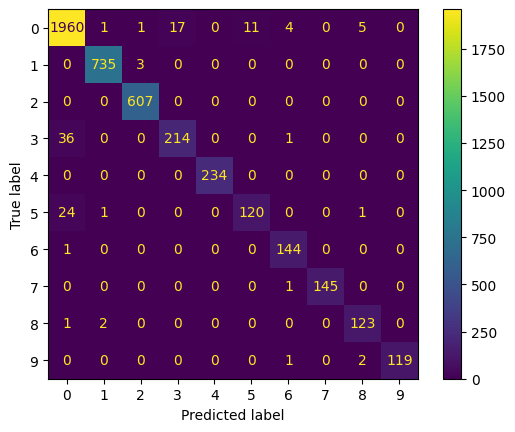

<Figure size 2000x1500 with 0 Axes>

In [ ]:
classes_ = np.unique(np.concatenate((y_true, y_pred)))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels= classes_).plot()
plt.figure(figsize= (20,15))

print(classification_report(y_true, y_pred))

Ahora modifico la matriz de confusión para ver de una forma más clara cuáles son las columnas que más fallan. Hay que verlo con perspectiva y tener en cuenta que las clases están desbalanceadas. Si una categoría que aparece 600 veces la predice mal en 20 ocasiones y una que aparece en 40 ocasiones la predice mal 15, aparecerá en un azul más oscuro la primera de ellas pero realmente la está clasificando mejor que la segunda.

<function matplotlib.pyplot.show(close=None, block=None)>

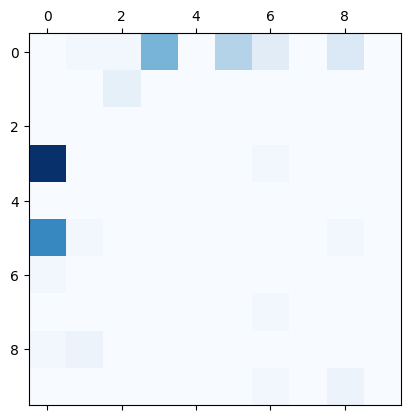

In [ ]:
np.fill_diagonal(cm, 0)
plt.matshow(cm, cmap= "Blues")
plt.show

Ahora lo mismo pero con el conjunto de prueba

In [ ]:
# Sólo test

y_true = []
y_pred = []

for batch in test_dataset:
    features, labels = batch
    predictions = Dcnn(features, training=False)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Convertir a arrays de numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       636
           1       0.96      0.96      0.96       225
           2       0.93      0.97      0.95       191
           3       0.81      0.65      0.72        80
           4       1.00      0.99      0.99        74
           5       0.47      0.61      0.53        38
           6       0.88      0.88      0.88        48
           7       1.00      0.91      0.96        47
           8       0.67      0.69      0.68        42
           9       0.90      0.72      0.80        39

    accuracy                           0.90      1420
   macro avg       0.85      0.83      0.84      1420
weighted avg       0.90      0.90      0.90      1420



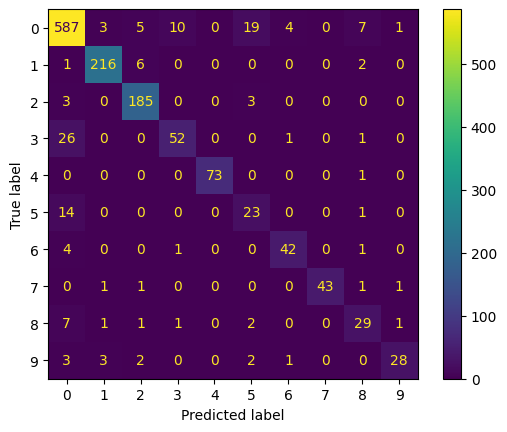

<Figure size 1500x1000 with 0 Axes>

In [ ]:
classes_ = np.unique(np.concatenate((y_true, y_pred)))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels= classes_).plot()
plt.figure(figsize= (15,10))

print(classification_report(y_true, y_pred))

<function matplotlib.pyplot.show(close=None, block=None)>

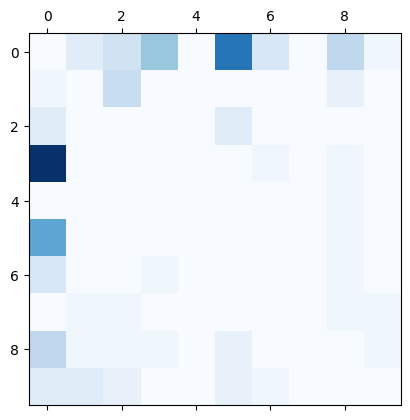

In [ ]:
np.fill_diagonal(cm, 0)
plt.matshow(cm, cmap= "Blues")
plt.show

El conjunto de entrenamiento cuenta con un 97% de accuracy frente a un 90% en el conjunto de prueba. Se ve que las clases que peor predice el modelo son la 3 y la 5. En la memoria del proyecto se da una explicación a este problema.

In [ ]:
data_final["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       3342
['Soporte Gestion Usuarios']           1174
['Soporte Utilities PyC']              1034
['ADM SISTEMAS', 'Soporte BackUp']      445
['SoporteFunc BiscayTIk']               371
['ADM SISTEMAS', 'Soporte Windows']     267
['OPERACION']                           258
['Negocio']                             235
['Soporte Herramientas de Gestion']     229
['Soporte Comunicaciones']              205
Name: count, dtype: int64

In [ ]:
data_final["categoria"].value_counts()

categoria
0    3342
1    1174
2    1034
3     445
4     371
5     267
6     258
7     235
8     229
9     205
Name: count, dtype: int64